In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
from torch.utils.data import DataLoader, TensorDataset

# Data

In [2]:
LOCATION = "Nelson St"

In [3]:
cycle_counts = pd.read_csv("cycle_counts.csv", parse_dates=["time"])
cycle_counts = cycle_counts[cycle_counts["location"] == LOCATION]

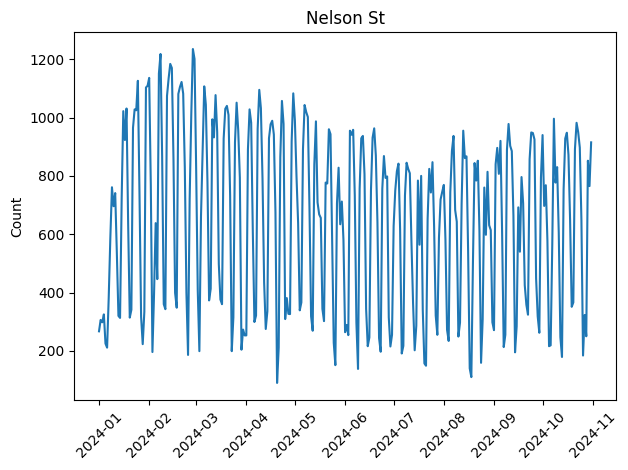

In [4]:
fig, ax = plt.subplots()
ax.plot(cycle_counts["time"], cycle_counts["count"], lw=1.5)
ax.set(title=LOCATION, ylabel="Count")
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
fig.tight_layout();

In [5]:
cycle_counts["time"] = pd.to_datetime(cycle_counts["time"])
cycle_counts = cycle_counts.set_index("time").drop(columns=["location"])
cycle_counts = cycle_counts.resample("D").sum().interpolate()

# RNNs

In [ ]:
# Start by predicting only the next timestamp

In [13]:
class RNN_1(nn.Module):
    def __init__(self, input_size: int = 1, hidden_size: int = 25):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.ih = nn.Linear(in_features=input_size, out_features=hidden_size)
        self.hh = nn.Linear(in_features=hidden_size, out_features=hidden_size)
        self.ho = nn.Linear(in_features=hidden_size, out_features=1)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Reshape to (batch_size, seq_len)
        x = x.view(-1, 3)
        
        # Initialise the hidden state
        h = torch.zeros(1, self.hidden_size, dtype=torch.float32)
        
        # Hidden state after first input
        h = F.relu(self.ih(x[:, 0].view(-1, 1)) + self.hh(h))

        # Hidden state after second input
        h = F.relu(self.ih(x[:, 1].view(-1, 1)) + self.hh(h))

        # Hidden state after thrid input
        h = F.relu(self.ih(x[:, 2].view(-1, 1)) + self.hh(h))

        # Output based on current hidden state
        return self.ho(h)

In [ ]:
class Scaler():
    def __init__(self):
        self.mean_: float | None = None
        self.scale_: float | None = None
    
    @property
    def is_fit(self) -> bool:
        return self.mean_ is not None and self.scale_ is not None
    
    def fit_transform(self, y: pd.Series) -> pd.Series:
        self.mean_ = y.mean()
        self.scale_ = y.std()
        return self.transform(y)

    def transform(self, y: pd.Series) -> pd.Series:
        assert self.is_fit
        return (y - self.mean_) / self.scale_

    def inverse_transform(self, y: pd.Series) -> pd.Series: 
        assert self.is_fit
        return y * self.scale_ + self.mean_

In [48]:
scaler = Scaler()
y_transformed = scaler.fit_transform(cycle_counts["count"])

in_seq_len = 3
out_seq_len = 1
y_train, y_test = [], []
for i in range(len(y_transformed) - in_seq_len - out_seq_len):
    train_seq = y_transformed.iloc[i: i + in_seq_len]
    y_train.append(train_seq.values)

    test_seq = y_transformed.iloc[i + in_seq_len: i + in_seq_len + out_seq_len]
    y_test.append(test_seq.values)

y_train = np.array(y_train).reshape(-1, in_seq_len)
y_test = np.array(y_test).reshape(-1, out_seq_len)

y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [ ]:
# Training loop

## LSTM

In [ ]:
x_start, x_end = 0, 100
n_samples = 1000
noise = 0.0

x = np.linspace(x_start, x_end, num=n_samples)
y = np.sin(x) ** 2 + 0.5 * np.cos(x) + np.random.normal(loc=0, scale=noise, size=n_samples)
plt.plot(x, y)

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, output_size=1, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)
        return out

In [ ]:
lstm = LSTMModel(input_size=1, hidden_size=50, output_size=1, num_layers=1)

In [ ]:
# Prepare the data
xs = []
ys = []

for i in range(len(y) - 1):
    xs.append(y[i])
    ys.append(y[i + 1])

xs = np.array(xs).reshape(-1, 1)
xs = torch.tensor(xs, dtype=torch.float32)

ys = np.array(ys).reshape(-1, 1)
ys = torch.tensor(ys, dtype=torch.float32)

In [ ]:
# Train the model
criterion = nn.MSELoss()
optimizer = Adam(lstm.parameters(), lr=0.01)
num_epochs = 100
for epoch in range(num_epochs):
    lstm.train()
    optimizer.zero_grad()
    
    # Forward pass
    y_hat = lstm(xs)
    loss = criterion(y_hat, ys)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

In [ ]:
# Fitted values
lstm.eval()
with torch.no_grad():
    y_hat = lstm(xs)
y_hat = y_hat.numpy()

plt.plot(np.arange(len(y)), y, label='Original values', color='blue')
plt.plot(np.arange(len(y_hat)), y_hat, label='Fitted values', color='red')

In [ ]:
# https://www.youtube.com/watch?v=RHGiXPuo_pI
# article on LSTMs, RNNs, and GRUs

### Going further with RNNs

In [ ]:
# Useful resources:
# https://medium.com/@imjeremyhi/understanding-recurrent-networks-part-1-simple-rnn-lstm-cc53e7475980
# https://github.com/fastai/fastbook/blob/master/12_nlp_dive.ipynb

In [ ]:
# Predict next value based on the last 10 values
x_start, x_end = 0, 100
n_samples = 1000
noise = 0.0

x = np.linspace(x_start, x_end, num=n_samples)
y = np.sin(x) + np.cos(0.5 * x) + 0.4 * np.cos(0.1 * x)
plt.plot(x, y)

In [ ]:
seq_len = 3
xs, ys = [], []
for i in range(len(y) - seq_len):
    xs.append(y[i:i + seq_len])
    ys.append(y[i + seq_len])

xs = np.array(xs).reshape(-1, seq_len)
xs = torch.tensor(xs, dtype=torch.float32)

ys = np.array(ys).reshape(-1, 1)
ys = torch.tensor(ys, dtype=torch.float32)

In [ ]:
class RNN1(nn.Module):
    def __init__(self, input_size=1, hidden_size=25):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.ih = nn.Linear(input_size, hidden_size)
        self.hh = nn.Linear(hidden_size, hidden_size)
        self.ho = nn.Linear(hidden_size, 1)
    
    def forward(self, x: torch.Tensor):
        x = x.view(-1, 3)  # Reshape to (batch_size, seq_len)
        h = torch.zeros(x.shape[0], self.hidden_size)
        h = F.relu(self.ih(x[:, 0].view(-1, 1)) + self.hh(h))  # .view(-1, 1) to make it 2D
        h = F.relu(self.ih(x[:, 1].view(-1, 1)) + self.hh(h))
        h = F.relu(self.ih(x[:, 2].view(-1, 1)) + self.hh(h))
        return self.ho(h)

In [ ]:
# Define model
rnn_model = RNN1(input_size=1, hidden_size=25)

# Define data loaders
dataset = TensorDataset(xs, ys)
dataloader = DataLoader(dataset, batch_size=32)

criterion = nn.MSELoss()
optimizer = Adam(rnn_model.parameters(), lr=0.01)
num_epochs = 100

rnn_model.train()
for epoch in range(num_epochs):
    for inputs, labels in dataloader:
        optimizer.zero_grad()
        outputs = rnn_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

In [ ]:
# Fitted values
rnn_model.eval()
with torch.no_grad():
    fitted_values = rnn_model(xs).view(-1)
fitted_values = fitted_values.numpy()

plt.plot(x, y, label='Original values', color='blue')
plt.plot(x[seq_len:], fitted_values, label='Fitted values', color='red')

## Forecasting several timestamps ahead

In [ ]:
# Predict next value based on the last 10 values
x_start, x_end = 0, 100
n_samples = 1000
noise = 0.2

x = np.linspace(x_start, x_end, num=n_samples)
y = np.sin(x) + np.cos(0.5 * x) + 0.4 * np.cos(0.1 * x) + np.random.normal(loc=0, scale=noise, size=n_samples)
plt.plot(x, y)

In [ ]:
in_seq_len = 60
out_seq_len = 21

xs, ys = [], []
for i in range(len(y) - in_seq_len - out_seq_len):
    xs.append(y[i:i + in_seq_len])
    for j in range(in_seq_len):
        ys.append(y[i + j + 1: i + j + out_seq_len + 1])

xs = np.array(xs).reshape(-1, in_seq_len)
ys = np.array(ys).reshape(-1, in_seq_len, out_seq_len)

In [ ]:
sample_idx = 4
fig, axes = plt.subplots(in_seq_len, 1, figsize=(10, in_seq_len * 1.5), sharex=True)
axes = axes.flatten()

for i in range(in_seq_len):
    axes[i].scatter(
        x[sample_idx:sample_idx + in_seq_len + out_seq_len],
        y[sample_idx:sample_idx + in_seq_len + out_seq_len],
        label='Original sequence',
        color='blue'
    )

    axes[i].plot(
        x[sample_idx:sample_idx + in_seq_len],
        xs[sample_idx],
        label='Input sequence',
        color='green',
        lw=2.5,
    )

    axes[i].plot(
        x[sample_idx + i + 1:sample_idx + i + out_seq_len + 1],
        ys[sample_idx, i],
        label='Output sequence',
        color='orange',
    )

fig.tight_layout();

In [ ]:
class RNN2(nn.Module):
    def __init__(
        self,
        in_seq_length: int,
        out_seq_len: int,
        input_size: int = 1,
        hidden_size: int = 25,
        batch_size: int = 32,
    ):
        super().__init__()
        self.in_seq_length = in_seq_length
        self.out_seq_len = out_seq_len
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.batch_size = batch_size
        self.ih = nn.Linear(input_size, hidden_size)
        self.hh = nn.Linear(hidden_size, hidden_size)
        self.ho = nn.Linear(hidden_size, out_seq_len)
    
    def forward(self, x: torch.Tensor, h: torch.Tensor | None = None):
        if h is None:
            h = torch.zeros(self.batch_size, self.hidden_size, dtype=torch.float32)
        
        outs = []
        for i in range(self.in_seq_length):
            h = F.relu(self.ih(x[:, i].view(-1, 1)) + self.hh(h))
            outs.append(self.ho(h))
        outs = torch.stack(outs, dim=1)
        return outs

In [ ]:
batch_size = 32

xs = torch.tensor(xs, dtype=torch.float32)
ys = torch.tensor(ys, dtype=torch.float32)

ds = TensorDataset(xs, ys)
dl = DataLoader(ds, batch_size=32, drop_last=True)

In [ ]:
rnn_model = RNN2(in_seq_length=in_seq_len, out_seq_len=out_seq_len, batch_size=batch_size)
criterion = nn.MSELoss()
optimizer = Adam(rnn_model.parameters(), lr=1e-03)

# Training loop
n_epochs = 250
rnn_model.train()
for epoch in range(n_epochs):
    for inputs, labels in dl:
        optimizer.zero_grad()
        outputs = rnn_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 1 == 0:
        print(f'Epoch [{epoch + 1}/{n_epochs}], Loss: {loss.item():.4f}')

In [ ]:
# Plot the fitted values for each batch
plt.plot(x, y)

for batch_idx, (inputs, _) in enumerate(dl):
    outputs = rnn_model(inputs).detach().numpy()
    x_start = batch_idx * batch_size + in_seq_len + 1
    x_end = x_start + out_seq_len
    plt.plot(x[x_start: x_end], outputs[0, -1, :], color="red")

## Multilayer RNN

In [ ]:
class RNN3(nn.Module):
    def __init__(
        self,
        in_seq_length: int,
        out_seq_len: int,
        input_size: int = 1,
        hidden_size: int = 25,
        batch_size: int = 32,
        num_layers: int = 1
    ):
        super().__init__()
        self.in_seq_length = in_seq_length
        self.out_seq_len = out_seq_len
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.batch_size = batch_size
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.ho = nn.Linear(in_features=hidden_size, out_features=out_seq_len)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out, _ = self.rnn(x)
        return self.ho(out)

In [ ]:
# Predict next value based on the last 10 values
x_start, x_end = 0, 100
n_samples = 1000
noise = 0.3

x = np.linspace(x_start, x_end, num=n_samples)
y = np.sin(x) + np.cos(0.5 * x) + 0.4 * np.cos(0.1 * x) + np.random.normal(loc=0, scale=noise, size=n_samples)
plt.plot(x, y)

In [ ]:
# Prepare datasets
in_seq_len = 60
out_seq_len = 21

xs, ys = [], []
for i in range(len(y) - in_seq_len - out_seq_len):
    xs.append(y[i:i + in_seq_len])
    for j in range(in_seq_len):
        ys.append(y[i + j + 1: i + j + out_seq_len + 1])

xs = np.array(xs).reshape(-1, in_seq_len, 1)
xs = torch.tensor(xs, dtype=torch.float32)

ys = np.array(ys).reshape(-1, in_seq_len, out_seq_len)
ys = torch.tensor(ys, dtype=torch.float32)

In [ ]:
batch_size = 32
ds = TensorDataset(xs, ys)
dl = DataLoader(ds, batch_size=32)

In [ ]:
rnn_model = RNN3(
    in_seq_length=in_seq_len,
    out_seq_len=out_seq_len,
    input_size=1,
    hidden_size=25,
    num_layers=3,
    batch_size=batch_size
)
criterion = nn.MSELoss()
optimizer = Adam(rnn_model.parameters(), lr=1e-03)

# Training loop
n_epochs = 200
rnn_model.train()
for epoch in range(n_epochs):
    for inputs, labels in dl:
        optimizer.zero_grad()
        outputs = rnn_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{n_epochs}], Loss: {loss.item():.4f}')

## Multilayer LSTM, Long Horizon